# ANOVA de un factor

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

## 1. Cargar base de datos
### *Lista con los nombres de las variables del dataframe

In [2]:
from sklearn.datasets import load_iris

iris_names = load_iris()
names = iris_names['feature_names']
names.append('class')

### *Construcción del dataframe

In [3]:
data, target = load_iris(return_X_y=True)
data = pd.DataFrame(data)
target = pd.DataFrame(target)
iris = pd.concat([data, target], axis=1)
iris.columns = names
iris['class'].replace({0: 'Iris-Setosa', 1: 'Iris-Versicolour', 2: 'Iris-Virginica'}, inplace = True)
iris.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),class
0,5.1,3.5,1.4,0.2,Iris-Setosa
1,4.9,3.0,1.4,0.2,Iris-Setosa
2,4.7,3.2,1.3,0.2,Iris-Setosa
3,4.6,3.1,1.5,0.2,Iris-Setosa
4,5.0,3.6,1.4,0.2,Iris-Setosa


## 2. Test de normalidad
### Hipótesis:
$$\begin{cases} { H }_{ 0 }: la \quad variable \quad procede \quad de \quad una \quad distribucion \quad normal \\ { H }_{ 1 }: la \quad variable \quad no \quad procede \quad de \quad una \quad distribucion \quad normal\end{cases}$$

In [4]:
p_values = pd.DataFrame(stats.normaltest(iris.iloc[:, :-1]).pvalue ,index = names[:-1]).T
p_values.style.applymap(lambda x: 'background-color : lightgreen' if x>=0.05 else 'background-color : salmon')

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,0.0568242,0.167241,8.67787e-49,1.99181e-30


En verde los valores estadísticamente no significativos ($p-valor \ge 0.05$) y en rojo los valores estadísticamente significativos ($p-valor<0.05$)

## 3. ANOVA de un factor
Es una técnica paramétrica en la que se intenta comparar las medias de tres o más grupos. Al ser una técnica paramétrica es necesario que se cumplan ciertos supuestos para que el p-valor asociado sea válido:
 1. Independencia. Las muestras deben ser independientes.
 2. Normalidad. Cada muestra debe provenir de una población normalmente distribuida.
 3. Homocedasticidad. Las desviaciones estándar de los grupos deben ser iguales.

### 3.1 Revisión de supuestos estadísticos

##### Independencia
Se conoce de antemano que las muestras recogidas en los tres grupos son independientes. 

##### Normalidad

In [5]:
print ('Setosa: ' + str(stats.normaltest(iris['sepal width (cm)'][iris['class'] == 'Iris-Setosa']).pvalue))
print ('Versicolour: ' + str(stats.normaltest(iris['sepal width (cm)'][iris['class'] == 'Iris-Versicolour']).pvalue))
print ('Virginica: ' + str(stats.normaltest(iris['sepal width (cm)'][iris['class'] == 'Iris-Virginica']).pvalue))

Setosa: 0.388916654112468
Versicolour: 0.48409071097159273
Virginica: 0.2770869880114645


Para cada grupo se acepta la hipótesis nula de que la distribución es normal

##### Homocedasticidad
Para demostrar la homocedasticidad se realiza el test de Levene el cual contrasta las siguientes hipótesis
$$\begin{cases} { H }_{ 0 }: Varianzas \quad iguales \\ { H }_{ 1 }: Varianzas \quad distintas \end{cases}$$

In [6]:
stats.levene(iris['sepal width (cm)'][iris['class'] == 'Iris-Setosa'], 
              iris['sepal width (cm)'][iris['class'] == 'Iris-Versicolour'],
              iris['sepal width (cm)'][iris['class'] == 'Iris-Virginica']).pvalue

0.5248269975064537

No hay evidencia para rechazar la hipótesis nula, por lo tanto, las varianzas de los grupos de consideran iguales.

#### Como se cumplen los tres supuestos, es posible realizar un ANOVA para detectar si existe diferencia entre los tipos de flores.

### 3.2 Aplicar Test ANOVA
#### Hipótesis:
$$\begin{cases} { H }_{ 0 }: { \mu  }_{ i }={ \mu  }_{ j } \\ { H }_{ 1 }: { \mu  }_{ i }\neq { \mu  }_{ j } \end{cases} \forall i\neq j$$

Se realiza la ANOVA para encontrar diferencia en el ancho del sépalo ("sepal width (cm)") entre las tres clases de flores

In [7]:
ANOVA_statistic, Pvalue = stats.f_oneway(iris['sepal width (cm)'][iris['class'] == 'Iris-Setosa'], 
                                         iris['sepal width (cm)'][iris['class'] == 'Iris-Versicolour'],
                                         iris['sepal width (cm)'][iris['class'] == 'Iris-Virginica'])

print('Estadístico de contraste: ' + str(ANOVA_statistic))
print('P-valor: ' + str(Pvalue))

Estadístico de contraste: 47.36446140299382
P-valor: 1.3279165184572242e-16


#### Se rechaza la hipótesis nula, por lo tanto, al menos una de las medias de los grupos es distinta

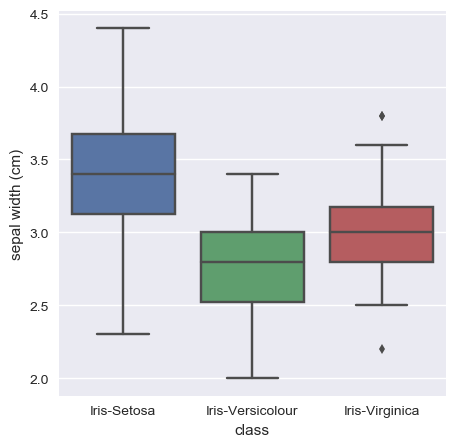

In [54]:
plt.figure(figsize=(5,5))
plt.style.use('seaborn')
sns.boxplot(x="class", y="sepal width (cm)", data=iris)

### 3.3 Pruebas PostHoc

In [55]:
from statsmodels.stats.multicomp import MultiComparison

model = MultiComparison(iris['sepal width (cm)'], iris['class'])
results = model.tukeyhsd()
results.summary()

group1,group2,meandiff,lower,upper,reject
Iris-Setosa,Iris-Versicolour,-0.648,-0.8092,-0.4868,True
Iris-Setosa,Iris-Virginica,-0.444,-0.6052,-0.2828,True
Iris-Versicolour,Iris-Virginica,0.204,0.0428,0.3652,True


#### Se observa que los tres grupos tienen una media distinta.

Otra manera de observar las comparaciones multiples es mediante el intervalo de confianza para la media de cada grupo. El gráfico para los intervalos de confianza de cada grupo se obtiene al ejecutar el código: *results.plot_simultaneous()*. 

A continuación se proporciona una serie de funciones que calculan el intervalo de confianza para la media de cada grupo considerado y posteriormente realiza un gráfico ilustrativo. 

In [10]:
def IC_mean(X, group, data, confidence=0.95, decimals=4):
    
    i = 0
    categories = data[group].unique()
    ICs = pd.DataFrame(index = categories, columns = ['LI', 'Mean', 'LS'])
    categories_len = len(data[group].unique())
    for category in data[group].unique():
        data_cat = data[X][data[group] == category]
        n = len(data_cat)
        m, se = round(data_cat.mean(), decimals), data_cat.sem()
        h = se * stats.t._ppf((1+confidence)/2., n-1)
        IC1 = round(m-h,decimals)
        IC2 = round(m+h,decimals)
        ICs.iloc[i, 0] = IC1
        ICs.iloc[i, 1] = m
        ICs.iloc[i, 2] = IC2
        i =i+1
        
    return(ICs)

ic_media = IC_mean('sepal width (cm)', 'class', iris)
ic_media

,LI,Mean,LS
Iris-Setosa,3.3097,3.418,3.5263
Iris-Versicolour,2.6808,2.77,2.8592
Iris-Virginica,2.8823,2.974,3.0657


In [44]:
def IC_plot(X, parameter = True):
    xmin = min(X.iloc[:,0])
    xmax = max(X.iloc[:,1])
    
    lista = []
    i=0
    colors = ['C0','C1','C2','C3','C4','C5','C6','C7','C8','C9']
    for random in enumerate(X.index):
        final = X.iloc[i,2] - X.iloc[i,0]
        plt.scatter(X.iloc[i,0], i+1, marker='|', s=500, c=colors[i])
        if parameter == True:
            plt.scatter(X.iloc[i,1], i+1, marker='x', s=50, c=colors[i])
        plt.scatter(X.iloc[i,2], i+1, marker='|', s=500, c=colors[i])
        plt.arrow(X.iloc[i,0], i+1, final, 0, width = 0.005, head_width = 0,
                  head_length = 0, color = colors[i], zorder = 3, label = X.index[i])   
        lista = np.concatenate((lista, i+1), axis=None)
        i=i+1
    
    
    plt.gca().axes.get_yaxis().set_ticklabels([X.index])
    plt.yticks(lista, (X.index).tolist(), fontsize = 13)
    plt.ylim(0.5, max(lista)+0.5)

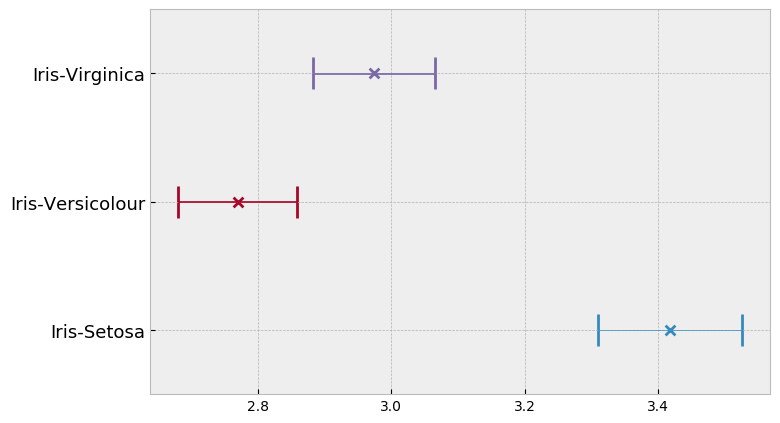

In [49]:
plt.figure(figsize=(8,5))
plt.style.use('bmh')
IC_plot(ic_media)

#### Ningún intervalo se intersecta, por lo tanto, los tres grupos tienen medias distintas
Iris-Setosa tiene la media del ancho del sépalo más alta, mientas que Iris-Versicolor tiene la media más baja